## **7주차 파이썬기초 강의 코드**

### 목차

- 실제 데이터 분석하기 

- 데이터 생성
- 다중 선형 회귀모형 적합 
- 다중공선성 VIF 체크
- 다중공선성 시각화로 확인하기 
- 변수 선택 
- 잔차검정
- 모형 결론
---

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

--- 
### **데이터 생성**


In [23]:

np.random.seed(42)

# 데이터 개수
n = 100

# x1 생성: 정규분포를 따르는 임의의 데이터
x1 = np.random.randn(n)

# x2 생성: x1과 강한 선형 관계를 가지도록 함 (다중공선성 문제)
x2 = 4*x1 + np.random.normal(scale=1, size=n)

# x3 생성: 부분적으로 x1의 영향을 받음 (잔차의 독립성 문제)
x3 = np.zeros(n)
x3[50:] = x1[50:] * 5 + np.random.normal(scale=5, size=n//2)

# y 생성: x1, x2, x3의 영향을 받되, 일부 데이터에 큰 오차를 추가하여 등분산성을 위반
y = 3*x1 + 2*x2 + x3 + np.random.randn(n) * 2
y[75:] = y[75:] + 50  # 특정 구간의 잔차가 커지도록 설정

# 데이터 프레임 생성
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3, 'y': y})


In [24]:
data

,x1,x2,x3,y
0,0.496714,0.571486,0.000000,0.111346
1,-0.138264,-0.973703,0.000000,-0.526474
2,0.647689,2.248040,0.000000,10.683457
3,1.523030,5.289842,0.000000,17.213704
4,-0.234153,-1.097899,0.000000,-5.936998
...,...,...,...,...
95,-1.463515,-5.468742,-8.990081,26.145989
96,0.296120,0.300624,-0.894125,47.699314
97,0.261055,1.197946,-1.961370,48.402761
98,0.005113,0.078663,8.852838,57.588616


--- 
### **다중 선형 회귀 적합 (Multiple Linear Regression)**


In [52]:
X = data[['x1', 'x2', 'x3']]
X = sm.add_constant(X)
model_selected_all = sm.OLS(y, X).fit()

print(model_selected_all.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     10.77
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           3.66e-06
Time:                        00:02:18   Log-Likelihood:                -447.90
No. Observations:                 100   AIC:                             903.8
Df Residuals:                      96   BIC:                             914.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9769      2.215      5.859      0.0

--- 
### **다중공선성(Multicollinearity)을 위한 VIF(Variance Inflation Factor) 체크**

> 아래 결과는 x1 과 x2 사이의 관계가 있음을 확인

In [53]:
def calculate_vif(data_frame):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame.values, i) for i in range(data_frame.shape[1])]
    return vif_data

print(calculate_vif(X.drop('const', axis=1)))

  Variable        VIF
0       x1  15.195640
1       x2  14.937861
2       x3   1.155412


--- 
### **다중공선성(Multicollinearity) 시각화로 확인하기**

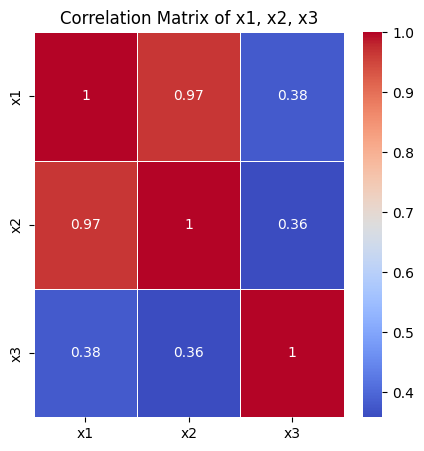

In [37]:
# 변수 간의 상관관계 히트맵 그리기
correlation_matrix = data[['x1','x2','x3']].corr()
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Matrix of x1, x2, x3")
plt.show()


/Users/home/Desktop/file/SKHU/skku_env/lib/python3.8/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 300x300 with 0 Axes>

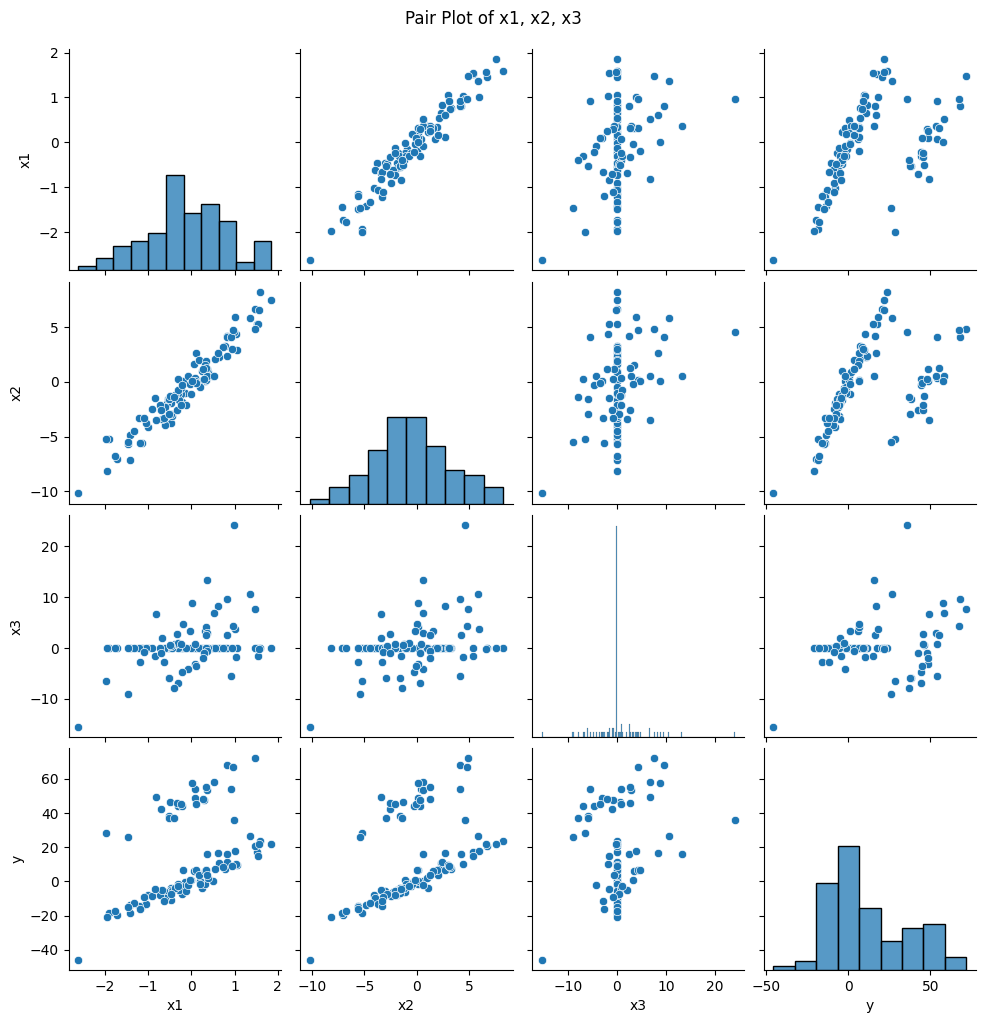

In [38]:
# 산점도 행렬 그리기
plt.figure(figsize=(3, 3))

sns.pairplot(data)
plt.suptitle("Pair Plot of x1, x2, x3", y=1.02)
plt.show()

--- 
### **변수 선택**
> x1,x3 선택

In [54]:
# x1, x3만 사용하는 새로운 모델을 생성
X_selected = X[['const', 'x1', 'x3']]
model_selected_x1_x3 = sm.OLS(y, X_selected).fit()

print(model_selected_x1_x3.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     15.73
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           1.21e-06
Time:                        00:02:40   Log-Likelihood:                -448.35
No. Observations:                 100   AIC:                             902.7
Df Residuals:                      97   BIC:                             910.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.0043      2.213      5.875      0.0

- 다중공선성을 통한 변수 선택
> x2,x3 선택

In [55]:
# x2, x3만 사용하는 새로운 모델을 생성
X_selected = X[['const', 'x2', 'x3']]
model_selected_x2_x3 = sm.OLS(y, X_selected).fit()

print(model_selected_x2_x3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     16.18
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           8.66e-07
Time:                        00:02:41   Log-Likelihood:                -448.01
No. Observations:                 100   AIC:                             902.0
Df Residuals:                      97   BIC:                             909.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.9185      2.202      5.866      0.0

In [58]:
# x2만 사용하는 새로운 모델을 생성
X_selected = X[['const', 'x2']]
model_selected_x2 = sm.OLS(y, X_selected).fit()

print(model_selected_x2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     31.83
Date:                Thu, 12 Oct 2023   Prob (F-statistic):           1.63e-07
Time:                        00:03:21   Log-Likelihood:                -448.34
No. Observations:                 100   AIC:                             900.7
Df Residuals:                      98   BIC:                             905.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.1646      2.177      6.048      0.0

--- 
### **모형 선택**

- AIC 기준 

In [61]:
# AIC 기준
print('x1,x2,x3 모든 변수 사용 AIC',model_selected_all.aic) 
print('x1,x3 변수 사용 AIC',model_selected_x1_x3.aic) 
print('x2,x3 변수 사용 AIC',model_selected_x2_x3.aic) 
print('x2 모든 변수 사용 AIC',model_selected_x2.aic) 

x1,x2,x3 모든 변수 사용 AIC 903.7928897389357
x1,x3 변수 사용 AIC 902.7040104030883
x2,x3 변수 사용 AIC 902.0138165255244
x2 모든 변수 사용 AIC 900.6733635272101


- 최종 모형 선택

In [63]:
model_selected = model_selected_x2

--- 
### **잔차 검정**

In [64]:
# 잔차
residuals = model_selected.resid

# 적합값
fitted = model_selected.fittedvalues

- 잔차 정규성 검정

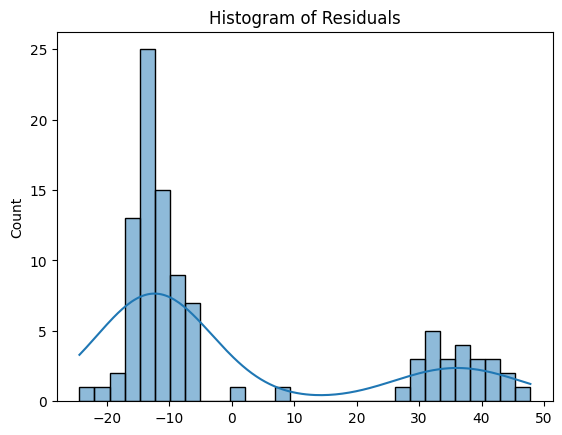

In [65]:
# 1. 잔차의 정규성
# 히스토그램
sns.histplot(residuals, kde=True, bins=30)
plt.title('Histogram of Residuals')
plt.show()


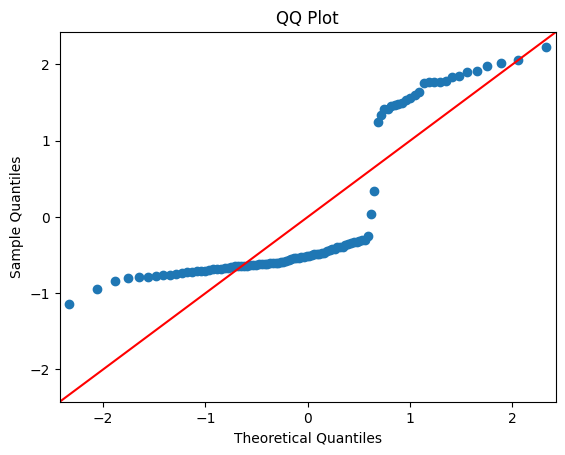

In [66]:

# QQ-plot
fig = sm.qqplot(residuals, fit=True, line='45')
plt.title('QQ Plot')
plt.show()

In [67]:
# Shapiro-Wilk 테스트
_, p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk p-value: {p_value:.4f}')

Shapiro-Wilk p-value: 0.0000


- 잔차의 독립성 검정

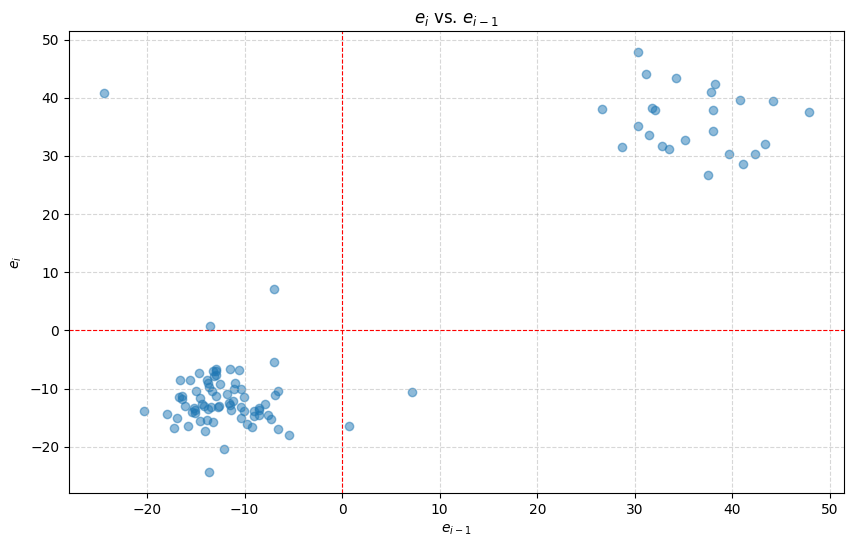

In [68]:
# ei와 e(i-1) 데이터 생성
ei = residuals[1:]
ei_minus_1 = residuals[:-1]

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.scatter(ei_minus_1, ei, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', linewidth=0.8)  # y=0 reference line
plt.axvline(x=0, color='r', linestyle='--', linewidth=0.8)  # x=0 reference line
plt.title('$e_i$ vs. $e_{i-1}$')
plt.xlabel('$e_{i-1}$')
plt.ylabel('$e_i$')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [70]:
# Durbin-Watson 테스트 (2기준)
dw_stat = sm.stats.durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw_stat:.4f}')

Durbin-Watson statistic: 0.1843


- 잔차의 등분산성 검정

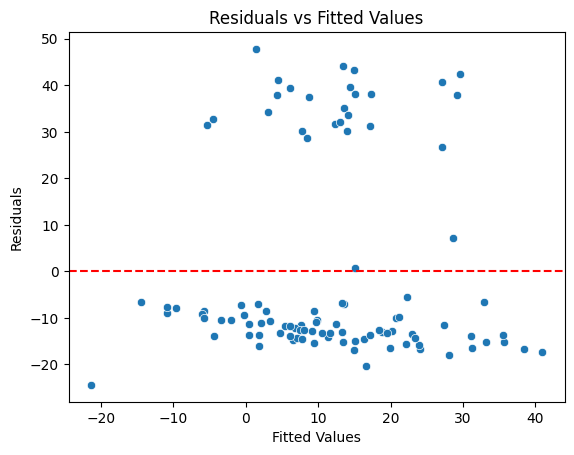

In [71]:
# 3. 잔차의 등분산성
# 잔차 vs. 적합값 플롯
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


In [73]:
# Breusch-Pagan 테스트
_, p_value, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals, X)
print(f'Breusch-Pagan test p-value: {p_value:.4f}')

Breusch-Pagan test p-value: 0.9170


--- 
### **모형 결론** ###

- 데이터 분포 : 양봉형
- 잔차 정규성 검정 : 정규성 X 
- 잔차 독립성 검정 : 독립성 X (양의 상관관계)
- 잔차 등분산성 검정 : 등분산 O 

1. 양봉형 분포 & 정규성 미충족
- 로그 변환이나 Box-Cox 변환을 이용하여 종속 변수의 분포를 더 정규성을 따르도록 함 

2. 독립성 문제
- 잔차끼리 상관성이 있다면 시계열 모형을 (예: ARIMA) 또는 Generalized Estimating Equation 모델을 고려 

3. 등분산성 만족
데이터가 등분산성을 만족한다면, 이에 대한 추가 대책은 필요하지 않습니다. 이는 단순 선형 회귀분석이나 다른 회귀 모형에 좋은 특성입니다.

- 추천 방안:
    - Generalized Linear Models (GLM): GLM은 정규 분포를 가정하지 않고 다른 종류의 분포를 모델링 할 수 있기 때문에, 양봉형이나 치우친 분포에 효과적입니다.
    - Quantile Regression: 이 방법은 종속 변수의 조건부 분위수를 모델링하므로, 종속 변수의 분포가 비정규적일 때 또는 이상치가 문제를 일으킬 때 유용합니다.
    - Robust Regression: 이 방법은 이상치에 덜 민감하며, 일부 데이터가 모델 가정을 위반할 때 사용할 수 있습니다.
    - Transformation: 위에서 언급한 것처럼, 로그 변환과 같은 기법은 종속 변수의 분포를 정규화하는 데 도움이 될 수 있습니다.
